In [1]:
# libraries
import pickle
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader
import numpy as np

# local files
import utils
from read_config import Config
import examine_model

# Finding secondary structure of GH5 using 3vdhas representative protein
### A note on variable names
#### There are three separate data sources involved here.
1. An alignment between only WT and 3vdh (aln)
2. Secondary structure of each residue according to pymol (pymol)
3. An alginment of the entire dataset (dataset)

In [2]:
from pymol import cmd
from pymol import stored

pdb_path = '../sequence_sets/3vdh.cif'
cmd.load(pdb_path)

stored.ss = ''
stored.seq = []
stored.i=0
# iterate through each residue, append secondary structure and residue to ss and seq
cmd.iterate('(n. CA)', 'stored.ss+=("%1s"%ss); stored.seq.append(oneletter)')

vdh_pymol_ss = stored.ss.replace(' ', '-')
vdh_pymol_seq = stored.seq

cmd.delete('all')

 PyMOL not running, entering library mode (experimental)


In [3]:
# here I load the MSA containing 3vdh
# TO BE CLEAR: this is a DIFFERENT MSA from the one we used to train the model

aln_config = Config('../config_3vdh.yaml')
aln_dataset = utils.get_dataset_from_config(aln_config)
aln_prots = utils.get_proteins_from_dataset(aln_dataset)

vdh_aln = aln_prots[-1]
wt_aln = aln_prots[0]

In [4]:
# for some reason the pymol seq has duplicate. IDK WHY
# here I manually delete them

vdh_aln_trim = [aa for aa in vdh_aln if not aa=='-']
vdh_ss = list(zip(vdh_pymol_seq, vdh_pymol_ss))
for i, aln_aa in enumerate(vdh_aln_trim):
    pymol_aa = vdh_ss[i][0]
    if not aln_aa==pymol_aa:
        if pymol_aa==vdh_ss[i-1][0]:
            print('deleting')
            del(vdh_ss[i])
            # yes, I know I'm modifying the list in a loop
            # but it works out
        else:
            print(i, vdh_aln_trim[i-2:i+2], vdh_ss[i-2:i+2])

deleting
deleting
deleting
deleting
deleting
deleting
deleting


In [5]:
# here I expand the ss to align with the aligned version of 3vdh
ss_aln = []
confirm_aln = []
i = 0
for aa in vdh_aln:
    if not aa=='-':
        ss_aln.append(vdh_ss[i][1])
        confirm_aln.append(vdh_ss[i][0])
        i+=1
    else:
        ss_aln.append('-')
        confirm_aln.append('-')
i = None
print(vdh_aln==confirm_aln)

True


In [6]:
# here I map the algined ss to the aligned WT sequence
# then remove gaps
wt_ss = list(zip(wt_aln, ss_aln))
wt_ss = [pair for pair in wt_ss if not pair[0] == '-']

In [7]:
# here I load the full dataset
dataset_config = Config('../config_1000_15.yaml')
dataset_dataset = utils.get_dataset_from_config(dataset_config)
dataset_prots = utils.get_proteins_from_dataset(dataset_dataset)

wt_dataset = dataset_prots[0]

In [8]:
# here I expand the ss of the WT to fit the full dataset alignment
ss_dataset = []
confirm_dataset = []
i = 0
for aa in wt_dataset:
    if not aa=='-':
        ss_dataset.append(wt_ss[i][1])
        confirm_dataset.append(wt_ss[i][0])
        i+=1
    else:
        ss_dataset.append('-')
        confirm_dataset.append('-')
i = None
print(confirm_dataset == wt_dataset)

True


# Graphing latent space vectors

In [9]:
config = Config('../config_1000_15.yaml')
dataset = utils.get_dataset_from_config(config)
seqs = list(dataset)
seqs = torch.stack([row[0] for row in seqs])
seqs = seqs.reshape(seqs.size()[0], -1, 21)
model = utils.load_model_from_config(config)

Loading saved model...


In [10]:
latent = pickle.load(open(config.latent_fullpath, 'rb'))['latent']
means = [row[0] for row in latent]
log_vars = [row[1] for row in latent]

In [11]:
def sample_from_vector(means, log_vars, sample_size):
    with torch.no_grad():
        outputs = []
        for i in range(sample_size):
            encoding = model.reparameterize(means, log_vars)
            output = model.decoder(encoding)
            outputs.append(output)
        outputs = torch.stack(outputs)
        recons = utils.softmax(outputs)
        # before reshape: sample_size x one_hot_encoding
        recons = recons.reshape(sample_size, -1, 21)
        # after reshape: sample_size x seq_length x amino_acids
    return recons

In [12]:
def explore_latent_vector(means, log_vars, sample_size=100):
    all_recons = {}

    with torch.no_grad():

        # all variation (normal sampling)
        # torch.stack([]) makes this a 2D tensor
        free_recons = sample_from_vector(means, log_vars, sample_size)
        all_recons['free'] = free_recons.reshape(1, *free_recons.size())

        # all fixed (no variation)
        fixed_outputs = []
        fixed_log_vars = torch.full(log_vars.size(), -float('inf')) # bc e^(-inf)=0
        fixed_recons = sample_from_vector(means, fixed_log_vars, sample_size)
        all_recons['fixed'] = fixed_recons.reshape(1, *fixed_recons.size())

        # one variation, others fixed
        single_free = []
        for free_var in range(len(log_vars)):
            single_free_log_vars = torch.full(log_vars.size(), -float('inf'))
            single_free_log_vars[free_var] = log_vars[free_var]
            single_free.append(sample_from_vector(means, single_free_log_vars, sample_size))
        all_recons['one_free']=torch.stack(single_free)
        
        # one fixed, others variation
        single_fixed = []
        for fixed_var in range(len(log_vars)):
            single_fixed_log_vars = log_vars.clone()
            single_fixed_log_vars[fixed_var] = -float('inf')
            single_fixed.append(sample_from_vector(means, single_fixed_log_vars, sample_size))
        all_recons['one_fixed'] = torch.stack(single_fixed)
            
    return all_recons

In [13]:
def explore_latent_origin(latent_size, sample_size=100):
    all_recons = {}
    # mean 0 and variance 1
    means = torch.zeros(latent_size)
    log_vars = torch.ones(latent_size)
    return explore_latent_vector(means, log_vars, sample_size=sample_size)

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def freqs_to_heatmap(freqs, adjustment=None, label='adjustment', xlabel=None):
    %matplotlib inline
    
    to_plot = []
    adjusted = freqs
    if not adjustment is None:
        adjusted = freqs-adjustment
        to_plot.extend(adjustment)
    to_plot.extend(adjusted)
    to_plot = torch.stack(to_plot)
    
    # current state of matrix: [#latents+stuff x #positions x amino_acids ]
    plottable = to_plot.transpose(1, 2)
    # current state of matrix: [#latents+stuff x amino_acids x #positions]
    plottable = plottable.reshape(-1, plottable.size()[-1])
    # current state of matrix: [(#latents*21 amino acids) x #positions]


    figure = plt.figure(figsize=(15,15), dpi=250)
    ax = plt.axes()
    ax.set_yticks(range(0, len(plottable), 21))
    ax.set_yticklabels([label, *range(0, len(plottable)-2)])
    if not xlabel==None:
        ax.set_xticks(range(0, len(plottable[0])))
        ax.set_xticklabels(ss_dataset,fontsize=3, color='red')
    ax.tick_params(colors='red')
    heatmap = ax.imshow(plottable)
    divider = make_axes_locatable(ax)
    
    ax.set_ylabel('Variation type', color='red')
    ax.set_xlabel('Position', color='red')

    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = figure.colorbar(heatmap, cax=cax)
    cbar.ax.tick_params(colors='red')
    
    return figure
    

In [15]:
input_wt = seqs[0]
trimmed_wt = [aa for aa in input_wt if not aa[-1]==0]
print(len(trimmed_wt))
print(len(wt_ss))

input_3vdh = seqs[-1]
aligned_ss = []
i = 0
for aa in input_wt:
    if not aa[-1] == 0:
        aligned_ss.append(wt_ss[i][1])
        i+=1
    else:
        aligned_ss.append('-')
i = None

latent_wt = (means[0], log_vars[0])

# these are all dictionaries of various latent sampling for different starting sequences
recons_wt = explore_latent_vector(means[0], log_vars[0], sample_size=10)
recons_3vdh = explore_latent_vector(means[-1], log_vars[-1], sample_size=10)
recons_o = explore_latent_origin(len(means[0]), sample_size = 10)



269
320


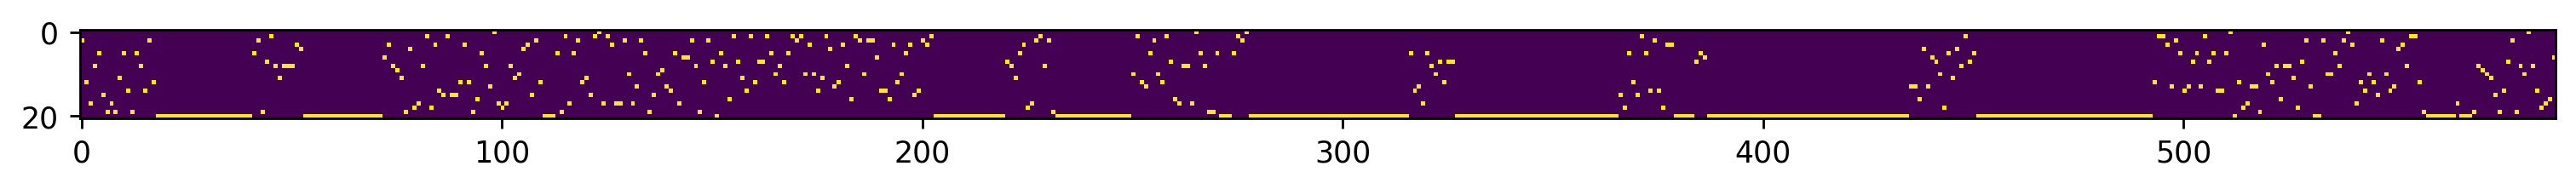

In [16]:
# this is a plot of structure vs sequence for WT

figure = plt.figure(figsize=(15,15), dpi=250)
ax = plt.axes()
ax.imshow(input_wt.transpose(0,1))

In [17]:
freqs_wt = examine_model.seqs_to_freqs_dict(recons_wt)
freqs_3vdh = examine_model.seqs_to_freqs_dict(recons_3vdh)
freqs_o = examine_model.seqs_to_freqs_dict(recons_o)

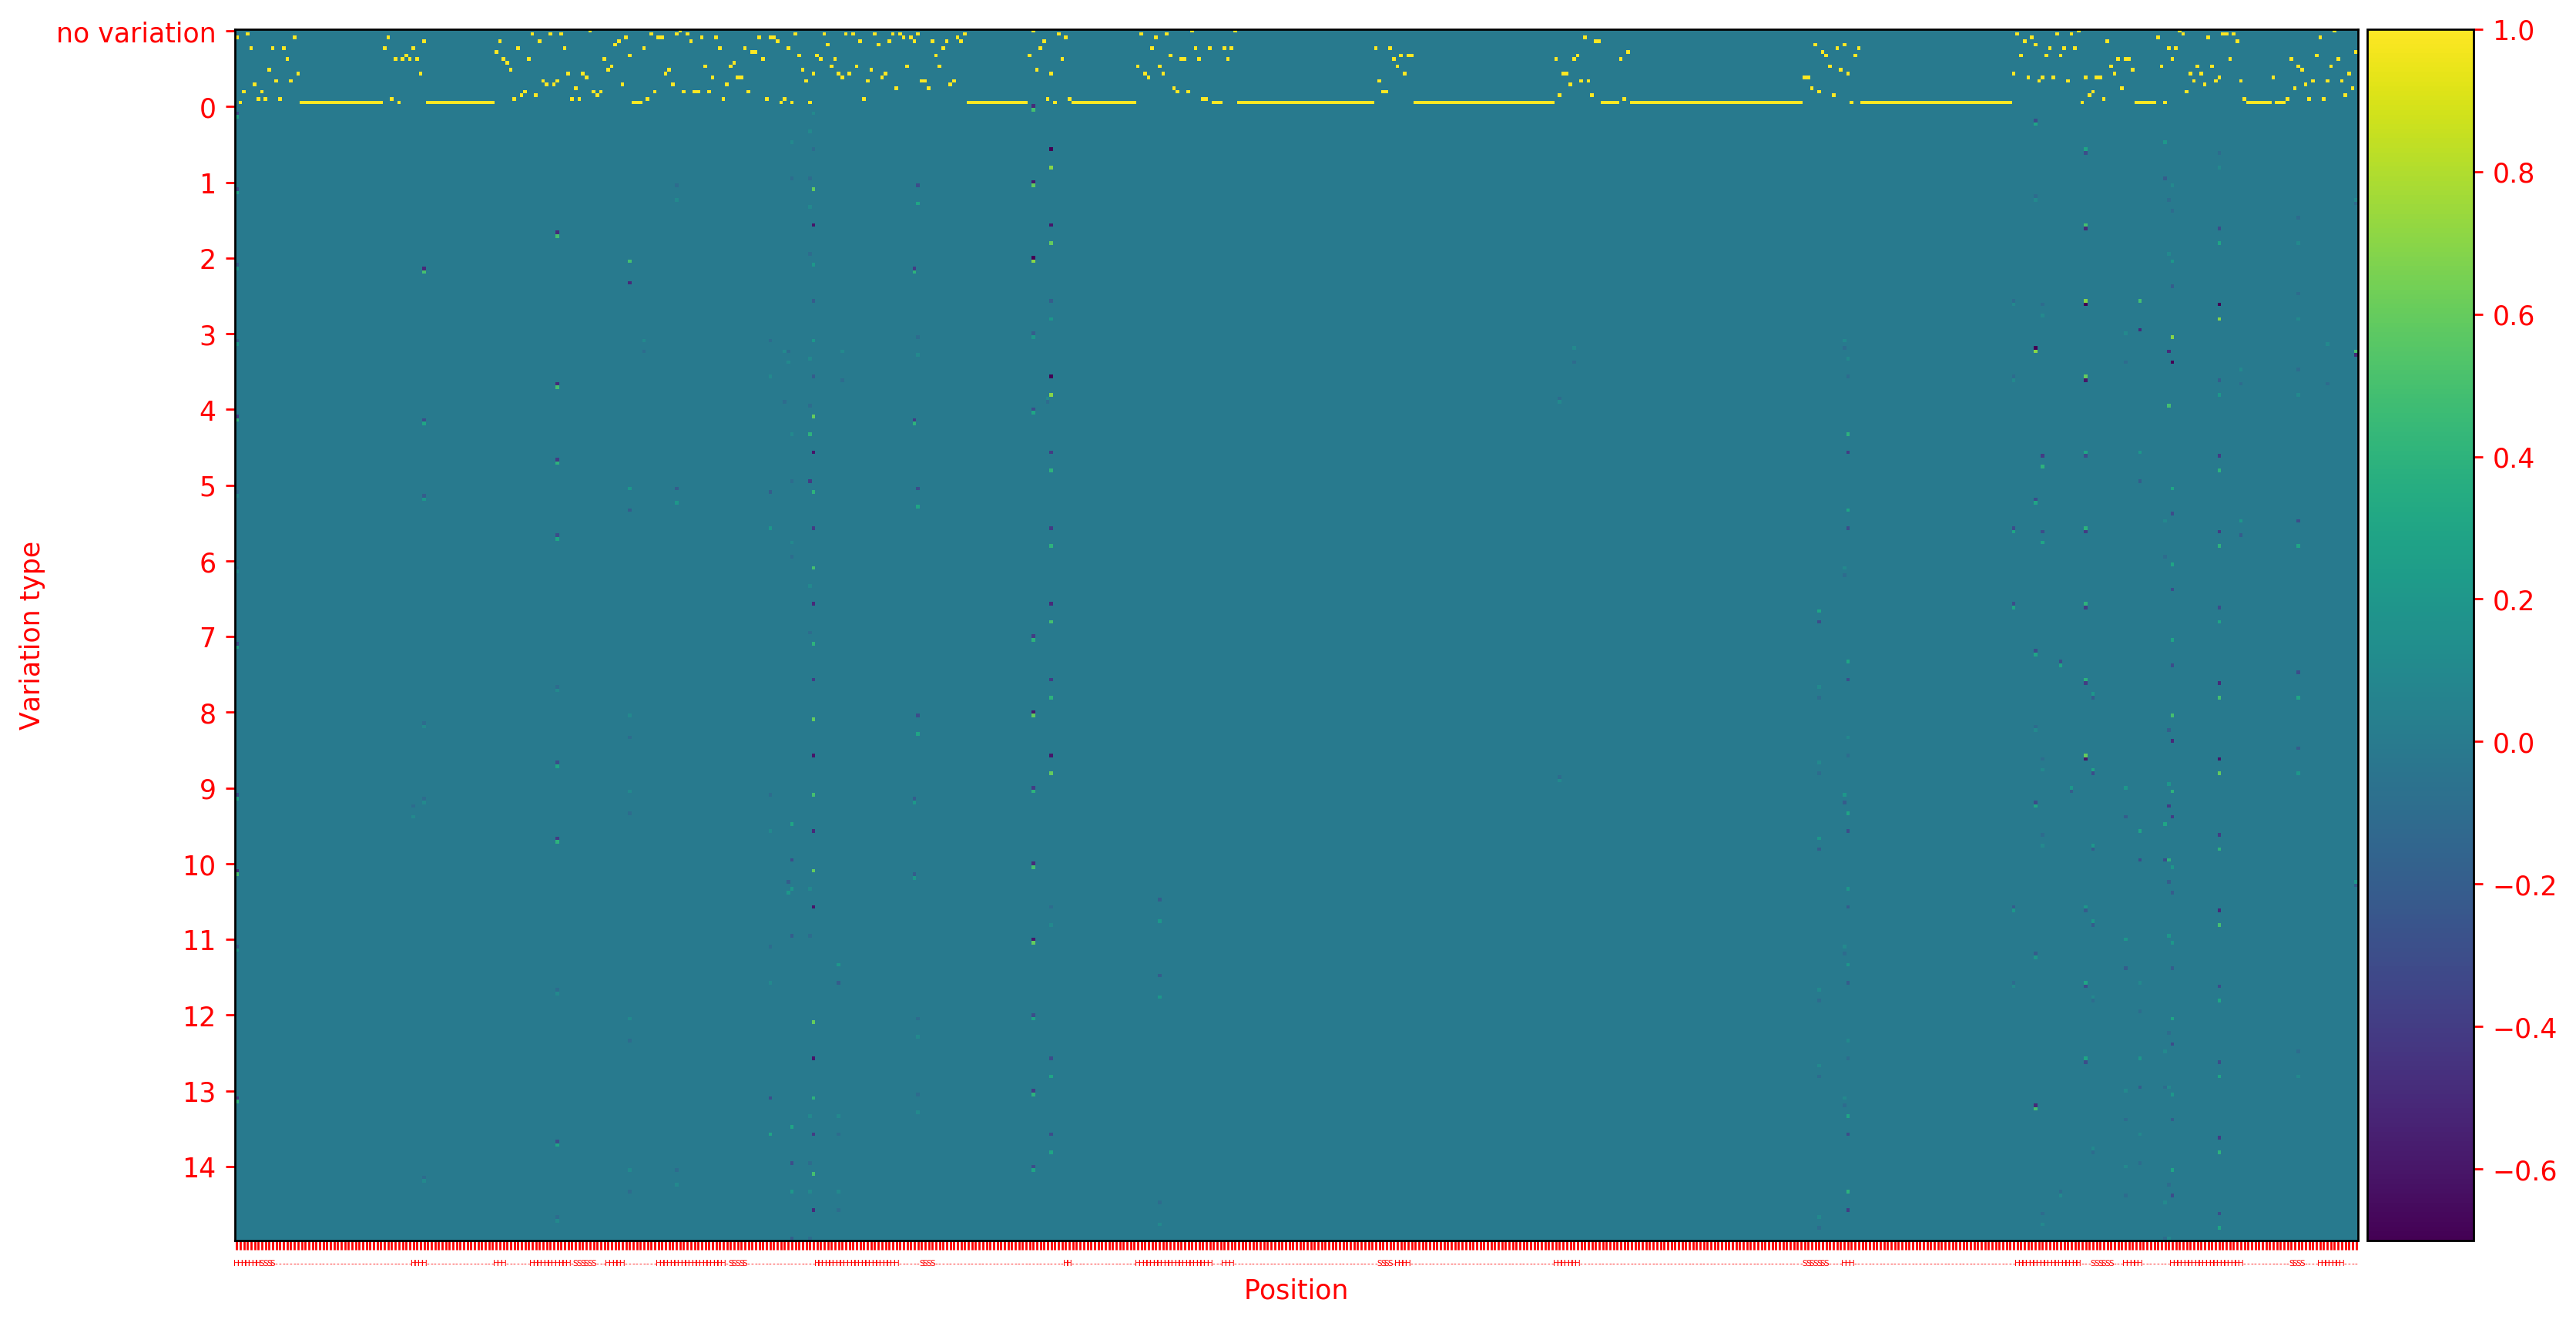

In [18]:
one_free_wt_fig = freqs_to_heatmap(freqs_wt['one_free'], adjustment=freqs_wt['fixed'],
                                   label='no variation', xlabel=ss_dataset)

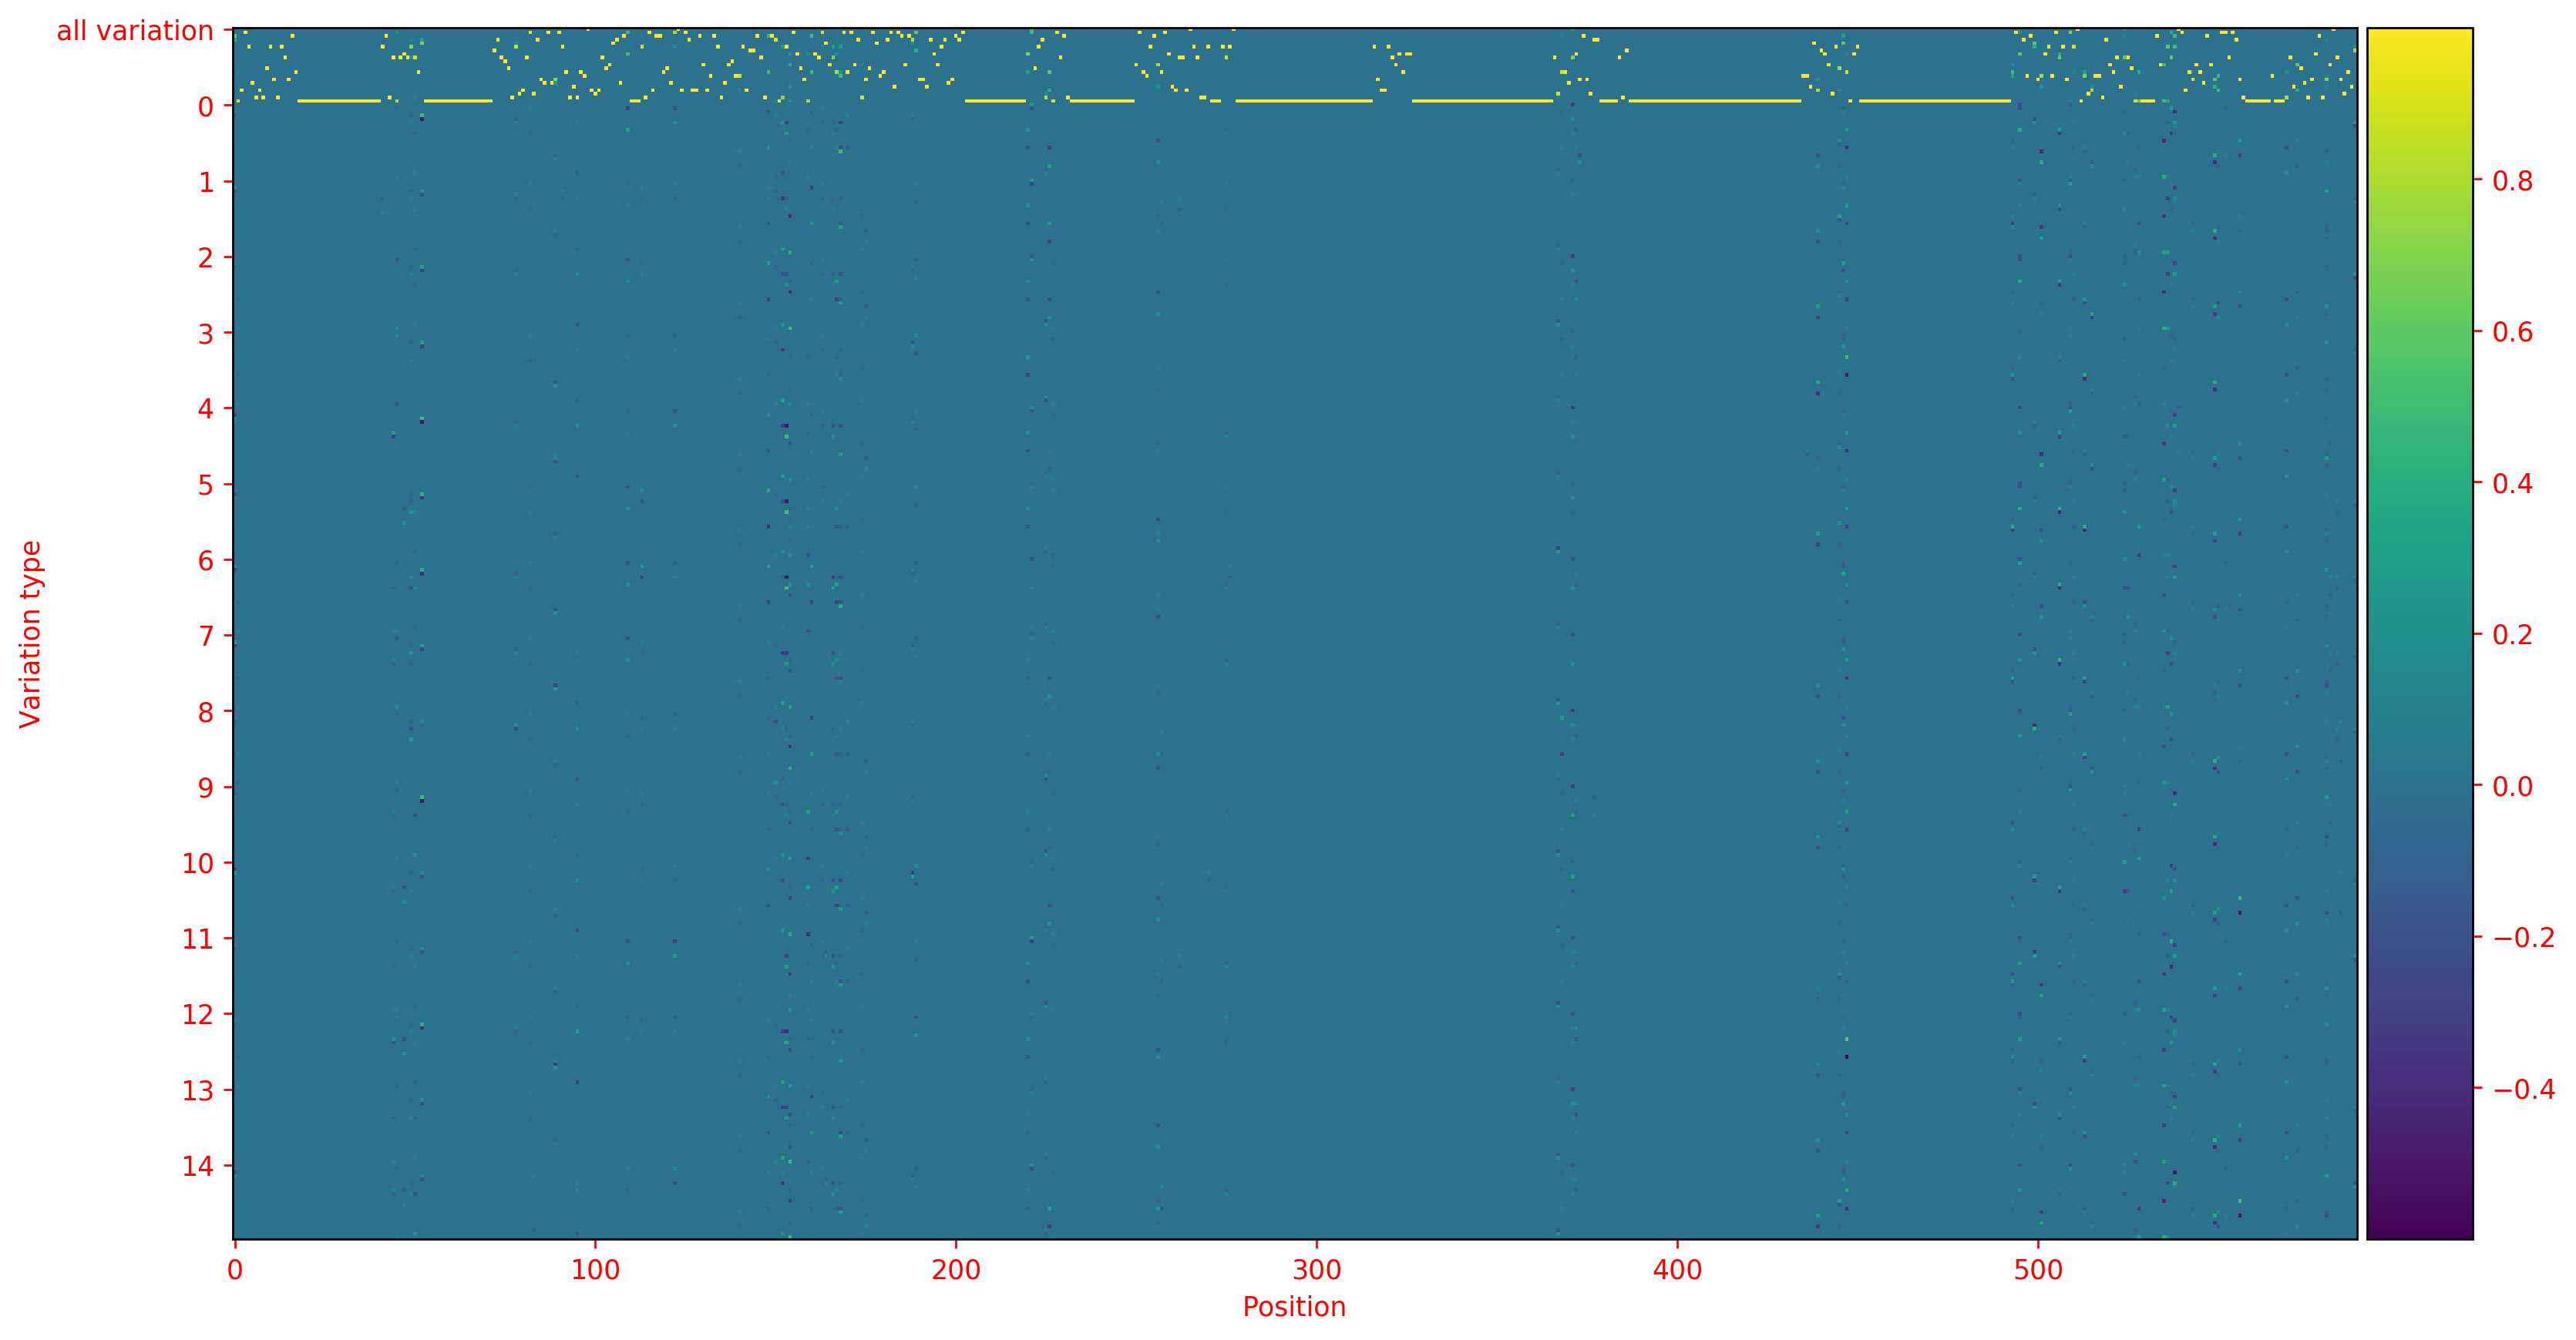

In [21]:
one_fixed_wt_fig = freqs_to_heatmap(freqs_wt['one_fixed'], adjustment=freqs_wt['free'], label='all variation')

In [22]:
def freqs_to_diversity(freqs_dict):
    # input tensor dimensions: latent_group x position x amino_acids
    # this is Shannon's index. IDK if it's a good metric, though
    divs = {}
    for key, freqs in freqs_dict.items():
        print(key)
        divs[key] = torch.tensor([[-torch.sum(pos[~(pos==0)]*torch.log(pos[~(pos==0)])) for pos in seq] for seq in freqs])
    return divs

def plot_diversity(div):
    fig = plt.figure(figsize=(30, 30), dpi=250)
    ax = plt.axes()
    ax.set_yticks(range(0,len(div)))
    ax.set_yticklabels(['Free', 'Fixed', *range(0, len(div)-2)], color='red')
    
    ax.tick_params(axis='y', labelsize=3)
    heatmap = ax.imshow(div)
    divider = make_axes_locatable(ax)

    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(heatmap, cax=cax)
    cbar.ax.tick_params(colors='red')

free
fixed
one_free
one_fixed


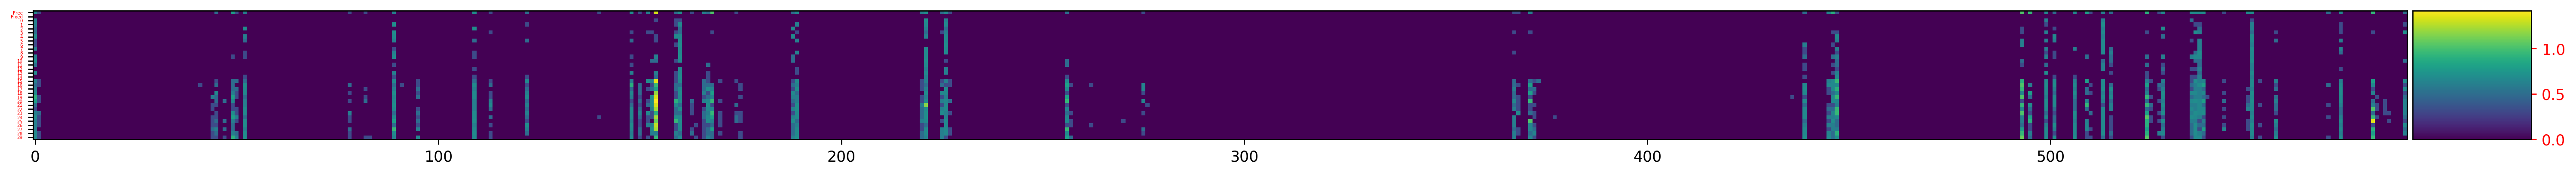

In [23]:
divs_wt = freqs_to_diversity(freqs_wt)
# here I change divs_wt to a list for plotting
# it is jank. I will fix later
plottable = []
for val in divs_wt.values():
    for div in val:
        plottable.append(div)

plottable = torch.stack(plottable)
divs_wt_fig = plot_diversity(plottable)

# Here I color 3vdh based on residue diversity

In [49]:
divs_3vdh = freqs_to_diversity(freqs_3vdh)
cmd.reinitialize('everything')
pdb_path = '../sequence_sets/3vdh.cif'
cmd.load(pdb_path)

free
fixed
one_free
one_fixed


In [50]:
cmd.alter('all', 'print(oneletter, resi);')

M 1
I 2
N 3
Q 4
N 5
A 6
T 7
T 7
T 7
T 7
T 7
T 7
T 7
Y 8
Y 8
Y 8
Y 8
Y 8
Y 8
Y 8
Y 8
Y 8
Y 8
Y 8
Y 8
M 9
M 9
M 9
M 9
M 9
M 9
M 9
M 9
E 10
E 10
E 10
E 10
E 10
E 10
E 10
E 10
E 10
E 11
E 11
E 11
E 11
E 11
E 11
E 11
E 11
E 11
S 12
S 12
S 12
S 12
S 12
S 12
A 13
A 13
A 13
A 13
A 13
Q 14
Q 14
Q 14
Q 14
Q 14
Q 14
Q 14
Q 14
Q 14
S 15
S 15
S 15
S 15
S 15
S 15
S 15
S 15
S 15
A 16
A 16
A 16
A 16
A 16
V 17
V 17
V 17
V 17
V 17
V 17
V 17
D 18
D 18
D 18
D 18
D 18
D 18
D 18
D 18
N 19
N 19
N 19
N 19
N 19
N 19
N 19
N 19
F 20
F 20
F 20
F 20
F 20
F 20
F 20
F 20
F 20
F 20
F 20
G 21
G 21
G 21
G 21
L 22
L 22
L 22
L 22
L 22
L 22
L 22
L 22
G 23
G 23
G 23
G 23
F 24
F 24
F 24
F 24
F 24
F 24
F 24
F 24
F 24
F 24
F 24
N 25
N 25
N 25
N 25
N 25
N 25
N 25
N 25
L 26
L 26
L 26
L 26
L 26
L 26
L 26
L 26
G 27
G 27
G 27
G 27
N 28
N 28
N 28
N 28
N 28
N 28
N 28
N 28
T 29
T 29
T 29
T 29
T 29
T 29
T 29
L 30
L 30
L 30
L 30
L 30
L 30
L 30
L 30
D 31
D 31
D 31
D 31
D 31
D 31
D 31
D 31
A 32
A 32
A 32
A 32
A 32
N 33
N 33
N 33
N 33
N 3

V 17
V 17
V 17
V 17
D 18
D 18
D 18
D 18
D 18
D 18
D 18
D 18
N 19
N 19
N 19
N 19
N 19
N 19
N 19
N 19
F 20
F 20
F 20
F 20
F 20
F 20
F 20
F 20
F 20
F 20
F 20
G 21
G 21
G 21
G 21
L 22
L 22
L 22
L 22
L 22
L 22
L 22
L 22
G 23
G 23
G 23
G 23
F 24
F 24
F 24
F 24
F 24
F 24
F 24
F 24
F 24
F 24
F 24
N 25
N 25
N 25
N 25
N 25
N 25
N 25
N 25
L 26
L 26
L 26
L 26
L 26
L 26
L 26
L 26
G 27
G 27
G 27
G 27
N 28
N 28
N 28
N 28
N 28
N 28
N 28
N 28
T 29
T 29
T 29
T 29
T 29
T 29
T 29
L 30
L 30
L 30
L 30
L 30
L 30
L 30
L 30
D 31
D 31
D 31
D 31
D 31
D 31
D 31
D 31
A 32
A 32
A 32
A 32
A 32
N 33
N 33
N 33
N 33
N 33
N 33
N 33
N 33
G 34
G 34
G 34
G 34
C 35
C 35
C 35
C 35
C 35
C 35
G 36
G 36
G 36
G 36
T 37
T 37
T 37
T 37
T 37
T 37
T 37
G 38
G 38
G 38
G 38
K 39
K 39
K 39
K 39
K 39
K 39
K 39
K 39
K 39
P 40
P 40
P 40
P 40
P 40
P 40
P 40
V 41
V 41
V 41
V 41
V 41
V 41
V 41
A 42
A 42
A 42
A 42
A 42
T 43
T 43
T 43
T 43
T 43
T 43
T 43
Y 44
Y 44
Y 44
Y 44
Y 44
Y 44
Y 44
Y 44
Y 44
Y 44
Y 44
Y 44
E 45
E 45
E 45
E 45
E 45
E 45


A 213
A 213
A 213
A 213
K 214
K 214
K 214
K 214
K 214
K 214
K 214
K 214
K 214
G 215
G 215
G 215
G 215
E 216
E 216
E 216
E 216
E 216
E 216
E 216
E 216
E 216
N 217
N 217
N 217
N 217
N 217
N 217
N 217
N 217
V 218
V 218
V 218
V 218
V 218
V 218
V 218
L 219
L 219
L 219
L 219
L 219
L 219
L 219
L 219
N 220
N 220
N 220
N 220
N 220
N 220
N 220
N 220
N 221
N 221
N 221
N 221
N 221
N 221
N 221
N 221
F 222
F 222
F 222
F 222
F 222
F 222
F 222
F 222
F 222
F 222
F 222
M 223
M 223
M 223
M 223
M 223
M 223
M 223
M 223
M 223
M 223
M 223
M 223
M 223
L 224
L 224
L 224
L 224
L 224
L 224
L 224
L 224
P 225
P 225
P 225
P 225
P 225
P 225
P 225
T 226
T 226
T 226
T 226
T 226
T 226
T 226
T 226
T 226
T 226
T 226
D 227
D 227
D 227
D 227
D 227
D 227
D 227
D 227
A 228
A 228
A 228
A 228
A 228
V 229
V 229
V 229
V 229
V 229
V 229
V 229
N 230
N 230
N 230
N 230
N 230
N 230
N 230
N 230
N 231
N 231
N 231
N 231
N 231
N 231
N 231
N 231
H 232
H 232
H 232
H 232
H 232
H 232
H 232
H 232
H 232
H 232
L 233
L 233
L 233
L 233
L 233
L 23

O 855
O 856
O 857
O 858
O 859
O 860
O 860
O 861
O 862
O 863
O 864
O 865
O 866
O 867
O 868
O 869
O 870
O 871
O 872
O 873
O 874
O 875
O 876
O 877
O 878
O 879
O 880
O 881
O 882
O 883
O 884
O 885
O 886
O 887
O 888
O 889
O 890
O 891
O 892
O 893
O 894
O 894
O 895
O 896
O 897
O 898
O 899
O 900
O 901
O 902
O 903
O 904
O 905
O 906
O 907
O 908
O 909
O 910
O 911
O 912
O 913
O 914
O 915
O 916
O 917
O 918
O 919
O 920
O 921
O 922
O 923
O 924
O 925
O 926
O 927
O 928
O 929
O 930
O 931
O 932
O 933
O 934


6448